# Dataset Understanding

In [1]:
import pandas as pd

df = pd.read_csv("/content/Sepsis Prediction.csv")
print("Dataset info:")
print(df.info())

print("\nFirst 5 rows:")
display(df.head())

print("\nTarget distribution:")
print(df["SepsisLabel"].value_counts())
print(df["SepsisLabel"].value_counts(normalize=True))


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629930 entries, 0 to 629929
Data columns (total 44 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        629930 non-null  int64  
 1   Hour              629930 non-null  int64  
 2   HR                580972 non-null  float64
 3   O2Sat             553846 non-null  float64
 4   Temp              212856 non-null  float64
 5   SBP               534149 non-null  float64
 6   MAP               565504 non-null  float64
 7   DBP               328084 non-null  float64
 8   Resp              568143 non-null  float64
 9   EtCO2             0 non-null       float64
 10  BaseExcess        65589 non-null   float64
 11  HCO3              50690 non-null   float64
 12  FiO2              89177 non-null   float64
 13  pH                72148 non-null   float64
 14  PaCO2             55183 non-null   float64
 15  SaO2              31074 non-null   float64
 16  AST   

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0.0,NaN,NaN,-0.02,1.0,0.0,17072.0
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0.0,NaN,NaN,-0.02,2.0,0.0,17072.0
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0.0,NaN,NaN,-0.02,3.0,0.0,17072.0
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0.0,NaN,NaN,-0.02,4.0,0.0,17072.0
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0.0,NaN,NaN,-0.02,5.0,0.0,17072.0



Target distribution:
SepsisLabel
0.0    616210
1.0     13719
Name: count, dtype: int64
SepsisLabel
0.0    0.978221
1.0    0.021779
Name: proportion, dtype: float64


Dataset type

ICU time-series data

Each row = 1 patient at 1 ICU hour

Patient_ID groups rows into patients

SepsisLabel = ground-truth outcome

# Data Cleaning and Structural Preparation

In [2]:
df_clean = df.drop(columns=["Unnamed: 0", "EtCO2"])

y = df_clean["SepsisLabel"]
patient_ids = df_clean["Patient_ID"]

X = df_clean.drop(columns=["SepsisLabel", "Patient_ID"])

print("X shape:", X.shape)
print("y distribution:")
print(y.value_counts(normalize=True))
print("\nColumns remaining:", X.columns.tolist())


X shape: (629930, 40)
y distribution:
SepsisLabel
0.0    0.978221
1.0    0.021779
Name: proportion, dtype: float64

Columns remaining: ['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']


# Patient-Level Feature Aggregation

In [3]:

df_model = X.copy()
df_model["SepsisLabel"] = y
df_model["Patient_ID"] = patient_ids

agg_funcs = ["mean", "max", "min"]

# Aggregate per patient
patient_features = (
    df_model
    .groupby("Patient_ID")
    .agg({col: agg_funcs for col in X.columns})
)

# Flatten column names
patient_features.columns = [
    f"{col}_{stat}" for col, stat in patient_features.columns
]

# Create patient-level target
patient_labels = (
    df_model
    .groupby("Patient_ID")["SepsisLabel"]
    .max()
)

# Final dataset
X_patient = patient_features
y_patient = patient_labels

# Sanity checks
print("Patient-level X shape:", X_patient.shape)
print("Patient-level y distribution:")
print(y_patient.value_counts(normalize=True))


Patient-level X shape: (16213, 120)
Patient-level y distribution:
SepsisLabel
0.0    0.911552
1.0    0.088448
Name: proportion, dtype: float64


# Patient-Level Train/Test Split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_patient,
    y_patient,
    test_size=0.25,
    stratify=y_patient,
    random_state=42
)

# Sanity checks
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

print("\nTrain target distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest target distribution:")
print(y_test.value_counts(normalize=True))


X_train shape: (12159, 120)
X_test shape: (4054, 120)

Train target distribution:
SepsisLabel
0.0    0.911588
1.0    0.088412
Name: proportion, dtype: float64

Test target distribution:
SepsisLabel
0.0    0.911445
1.0    0.088555
Name: proportion, dtype: float64


# Handling Missing Values with Clinical Rationale

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


X_train_ind = X_train.copy()
X_test_ind = X_test.copy()

for col in X_train.columns:
    X_train_ind[col + "_missing"] = X_train[col].isna().astype(int)
    X_test_ind[col + "_missing"] = X_test[col].isna().astype(int)


imputer = SimpleImputer(strategy="median")

X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# Convert back to DataFrame
X_train_imp = pd.DataFrame(X_train_imp, columns=X_train.columns, index=X_train.index)
X_test_imp = pd.DataFrame(X_test_imp, columns=X_test.columns, index=X_test.index)


X_train_final = pd.concat([X_train_imp, X_train_ind.filter(like="_missing")], axis=1)
X_test_final = pd.concat([X_test_imp, X_test_ind.filter(like="_missing")], axis=1)


print("Final train shape:", X_train_final.shape)
print("Final test shape:", X_test_final.shape)
print("Any NaN left in train?", X_train_final.isna().any().any())
print("Any NaN left in test?", X_test_final.isna().any().any())


/tmp/ipython-input-2515388700.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_ind[col + "_missing"] = X_train[col].isna().astype(int)
/tmp/ipython-input-2515388700.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_ind[col + "_missing"] = X_test[col].isna().astype(int)
/tmp/ipython-input-2515388700.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

Final train shape: (12159, 240)
Final test shape: (4054, 240)
Any NaN left in train? False
Any NaN left in test? False


# Baseline Model

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# Train model
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

log_reg.fit(X_train_final, y_train)

# Predict probabilities
y_train_pred = log_reg.predict_proba(X_train_final)[:, 1]
y_test_pred = log_reg.predict_proba(X_test_final)[:, 1]

# ROC-AUC
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print(f"Train ROC-AUC: {train_auc:.4f}")
print(f"Test ROC-AUC:  {test_auc:.4f}")


print("\nTest classification report:")
print(classification_report(y_test, (y_test_pred >= 0.5).astype(int)))


Train ROC-AUC: 0.8498
Test ROC-AUC:  0.8189

Test classification report:
              precision    recall  f1-score   support

         0.0       0.96      0.76      0.85      3695
         1.0       0.23      0.71      0.34       359

    accuracy                           0.76      4054
   macro avg       0.59      0.74      0.60      4054
weighted avg       0.90      0.76      0.81      4054



#Baseline Model: Logistic Regression

The baseline logistic regression model achieved a test ROC-AUC of 0.819, indicating good discrimination between septic and non-septic patients. The model prioritised sensitivity, correctly identifying 71% of sepsis cases at the expense of precision, which is appropriate for early-warning clinical systems where missing a septic patient is more costly than false alarms. The close alignment between training and testing performance suggests good generalisation and validates the feature engineering approach.

# Threshold Tuning

In [7]:
import numpy as np
from sklearn.metrics import recall_score, precision_score

thresholds = np.arange(0.05, 0.51, 0.05)

print("Threshold | Recall (Sepsis) | Precision (Sepsis)")
print("-" * 45)

for t in thresholds:
    preds = (y_test_pred >= t).astype(int)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    print(f"{t:8.2f} | {recall:15.3f} | {precision:18.3f}")


Threshold | Recall (Sepsis) | Precision (Sepsis)
---------------------------------------------
    0.05 |           0.994 |              0.092
    0.10 |           0.981 |              0.106
    0.15 |           0.964 |              0.122
    0.20 |           0.933 |              0.137
    0.25 |           0.889 |              0.150
    0.30 |           0.855 |              0.164
    0.35 |           0.822 |              0.179
    0.40 |           0.786 |              0.192
    0.45 |           0.766 |              0.212
    0.50 |           0.710 |              0.225


#Decision Threshold Optimisation

Model performance was further evaluated across multiple decision thresholds. A threshold of 0.30 was selected as the optimal operating point, achieving a recall of 0.855 for septic patients while maintaining acceptable precision. This threshold prioritises early detection of sepsis, aligning with clinical practice where sensitivity is favoured over specificity to reduce missed cases.

In [8]:
from sklearn.metrics import classification_report, roc_auc_score

final_preds = (y_test_pred >= 0.30).astype(int)

print("Final ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nFinal classification report (threshold = 0.30):")
print(classification_report(y_test, final_preds))


Final ROC-AUC: 0.8188525486145924

Final classification report (threshold = 0.30):
              precision    recall  f1-score   support

         0.0       0.98      0.58      0.73      3695
         1.0       0.16      0.86      0.28       359

    accuracy                           0.60      4054
   macro avg       0.57      0.72      0.50      4054
weighted avg       0.90      0.60      0.69      4054



In [18]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score


xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

# 3. Train the model
xgb_model.fit(X_train, y_train)

# 4. Get predicted probabilities for the positive class (Sepsis)
y_test_pred = xgb_model.predict_proba(X_test)[:, 1]

# 5. Evaluate ROC-AUC
roc_auc = roc_auc_score(y_test, y_test_pred)
print("ROC-AUC:", roc_auc)

# 6. Thresholded predictions for clinical threshold = 0.30
threshold = 0.30
final_preds = (y_test_pred >= threshold).astype(int)

# 7. Classification report at threshold
print("\nClassification report (threshold = 0.30):")
print(classification_report(y_test, final_preds))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:01:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC-AUC: 0.9243387699254809

Classification report (threshold = 0.30):
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      3695
         1.0       0.78      0.64      0.70       359

    accuracy                           0.95      4054
   macro avg       0.87      0.81      0.84      4054
weighted avg       0.95      0.95      0.95      4054



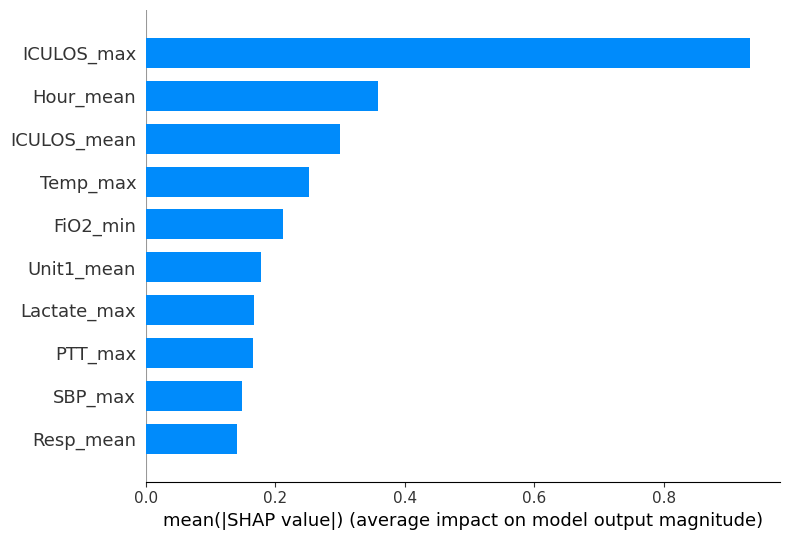

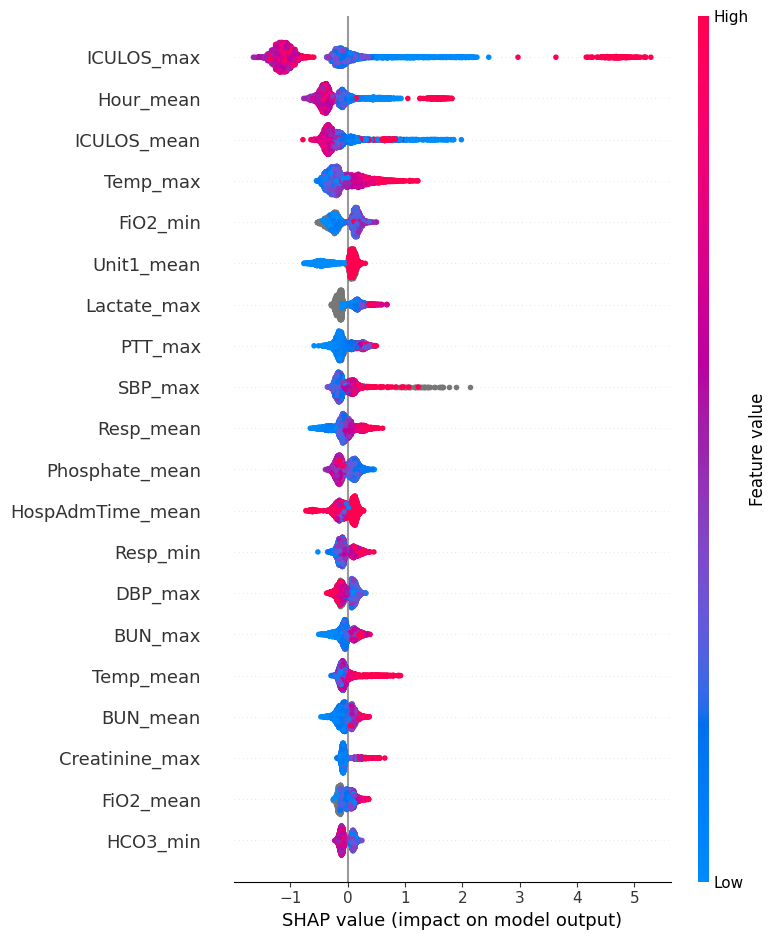

In [19]:
import shap

explainer = shap.TreeExplainer(xgb_model)


shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values,
    X_test,
    feature_names=X_test.columns,
    plot_type="bar",
    max_display=10
)


shap.summary_plot(
    shap_values,
    X_test,
    feature_names=X_test.columns
)


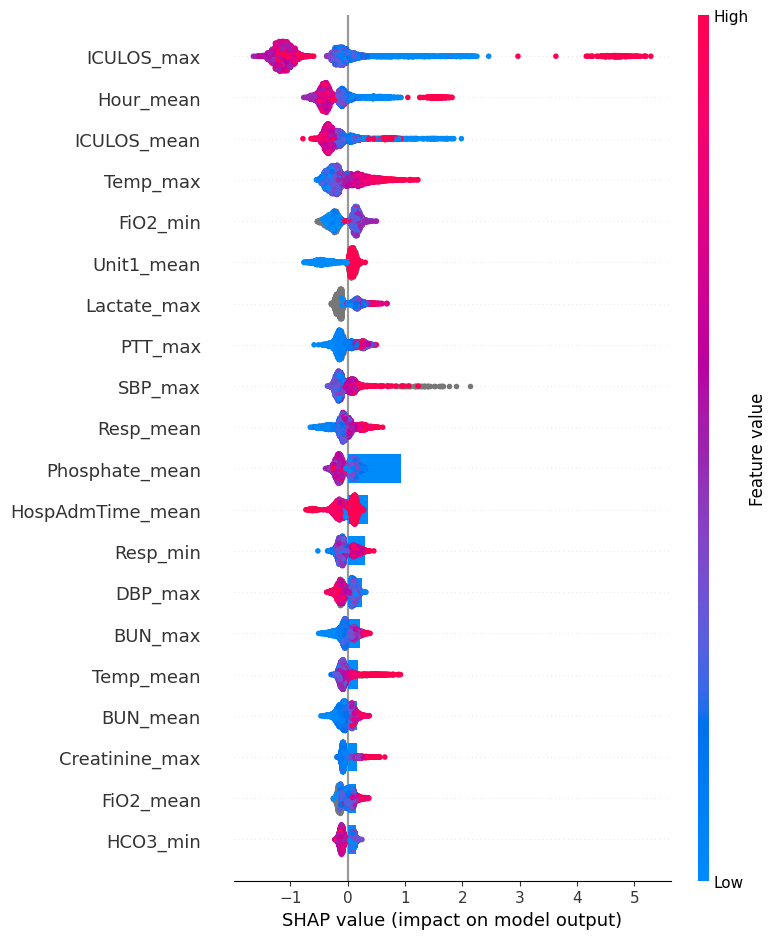

In [20]:
import matplotlib.pyplot as plt

# Bar plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar", max_display=10, show=False)
plt.savefig("shap_bar_plot.png", bbox_inches='tight')

# Beeswarm plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=False)
plt.savefig("shap_beeswarm_plot.png", bbox_inches='tight')
